# *Exercise: 2*

## *Theory:*
- **Required:** $\min_{x}f_\lambda (x)= \frac{\lambda}{2}x^{T}x + \frac{1}{2}\|Ax -y\|_2^2$
- **Gradient of the above function:** 
$\nabla f(x) = \lambda x + <A, Ax-y> = \lambda x + A^T Ax - A^\top y$

 We know that,
$\frac{\partial x^{T} Ax}{\partial x} = (A+A^{T} )x, \text{ and } \frac{\partial x ^{T} a}{\partial x} = \frac{\partial x a ^{T}}{\partial x} = a$

 Now, we have, 

$\begin{align*}
f(x) &= \frac{\lambda}{2}x^{T}x + \frac{1}{2}(Ax-y)^{T}(Ax-y)\\
&= \frac{1}{2} \Big[ \lambda x^{T}x + x^{T} A^{T} Ax - x^{T} A^{T} y -y ^{T} Ax +y^{T} y\Big]\\
\implies \nabla f(x) &= \frac{1}{2} \Big[2\lambda x + (A^{T} A+(A^{T} A)^{T})x - A^{T} y -(y^{T} A)^{T}\Big]\\
&= \frac{1}{2} \Big[2\lambda x + 2A^{T} Ax - 2A^{T} y\Big]\\
&= \lambda x + A^{T} Ax -A^{T}y
\end{align*}$
- **Hessian of the function:** $\nabla^2 f(x) = \lambda I + A^T A$


# *Question:1*

##Significance of the newly added regularizer term $\frac{\lambda}{2}x^{T}x$

> In the expression $f_\lambda = \frac{\lambda}{2}x^Tx + \frac{1}{2}||Ax-y||_2$, the regularizer term $\frac{\lambda}{2}x^Tx$ constrains/regularizes or shrinks the values of $x$, so as to avoid the risk of overfitting, or in terms of the problem, so as to avoid the $x$'s from getting too large (note that here our objective is to minimize $f_\lambda$) 

## Defining all the necessary methods to be used in finding the minimizers

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

In [2]:
def create_data():
    np.random.seed(1000)
    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)  
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)
    return A, x_bar, y

In [3]:
#Method to compute and return the function value 
def evalf(lambd, A, x, y):  
    assert type(lambd) is float
    assert type(x) is np.ndarray 
    assert x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]  
    temp = np.subtract(np.dot(A,x),y)
    fval = np.multiply((lambd/2), np.dot(x.T,x)) + 0.5*np.linalg.norm(temp,2)**2
    return fval

In [4]:
#Method to compute and return the gradient value 
def evalg(lambd, A, x, y):  
    assert type(lambd) is float
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    temp = np.dot(A,x) - y
    grad = np.add(np.multiply(lambd,x), np.dot(A.T,temp))
    return grad

In [5]:
#Method to compute and return the Hessian value 
def evalh(lambd, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    hess = np.multiply(lambd,np.identity(A.shape[1])) + np.matmul(A.T, A)
    return hess

In [6]:
#Method to construct D_k matrix used in Newton's method
def compute_D_k_newton(lambd, A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    d = np.linalg.inv(evalh(lambd, A, x))
    return d

In [7]:
#Method to compute the step length using backtracking
def compute_steplength_backtracking_scaled_direction(lambd, A, x, y, gradf, D_k, alpha_start, rho, gamma): #add appropriate arguments to the function 
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == A.shape[0]
    assert type(gradf) is np.ndarray and len(gradf) == 10 
    assert type(alpha_start) is float and alpha_start>=0. 
    assert type(rho) is float and rho>=0.
    assert type(gamma) is float and gamma>=0. 
    assert type(D_k) is np.ndarray and len(D_k) == 10  
    alpha = alpha_start
    p_k = -np.dot(D_k,gradf)
    while evalf(lambd, A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(lambd, A,x,y):
        alpha = rho*alpha  
    return alpha

In [8]:
#Line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [9]:
#Method to find the minimizer using Newton's method 
def find_minimizer_Newtonmethod(lambd, start_x, A, y, tol, line_search_type, *args):
    assert type(lambd) is float
    assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 
    x = start_x
    g_x = evalg(lambd, A, x, y)
    x_array = [x]
    f_array = [evalf(lambd, A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        d_k = compute_D_k_newton(lambd, A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(lambd, A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        # Gradient descent steps
        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x))) 
        k += 1 
        g_x = evalg(lambd, A, x, y) 
        x_array.append(x)
        f_array.append(evalf(lambd, A, x,y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(lambd, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

In [10]:
#Method to find minimizer using BFGS method 
def find_minimizer_BFGS(lambd, start_x, A, y, tol, line_search_type, *args):
    assert type(lambd) is float
    assert type(start_x) is np.ndarray  
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 
    x = start_x
    g_x = evalg(lambd, A, x, y)
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(lambd, A, x,y)]

    while (np.linalg.norm(g_x) > tol): 
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(lambd, A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        x_next = np.add(x, np.multiply(step_length,p)) 
        s_k = x_next - x
        y_k = evalg(lambd, A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1 
        x = x_next
        g_x = evalg(lambd, A, x, y)     
        x_array.append(x)
        f_array.append(evalf(lambd, A, x, y))
        if k % 4000 == 0:
            print('iter:',k, ' x:', x, ' f(x):', evalf(lambd, A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
    return x_array, f_array, k

### *Creating the data for $A, \bar{x}, y$*

In [11]:
#Generating x_bar, A, y for this Exercise
A, x_bar, y = create_data()

# *Question:3*
For $\lambda \in \{10^{-3}, 10^{-2},10^{-1}, 1\}$, performing the following: with a starting point of $x^0 = (0,0,...,0)^\top ∈ R^{10}$and solving the
problem using Newton and BFGS methods with backtracking line search use $α
0 = 0.99$,$ ρ = 0.5$, $γ = 0.5$
for backtracking line search and $τ = 10^{−5}$

In [12]:
#Newton's and BFGS method with backtracking search for different 
start_xs = []
for i in range(10):
  start_xs.append([0])
start_xs = np.array(start_xs)
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
lambda_array = [0.001, 0.01, 0.1, 1.0]
x_array_newton2 = [[] for _ in range(len(lambda_array))]
iters_newton2  = [0 for _ in range(len(lambda_array))]
f_array_newton2 = [[] for _ in range(len(lambda_array))]
times_newton2 = [0 for _ in range(len(lambda_array))]
x_array_bfgs2 = [[] for _ in range(len(lambda_array))]
iters_bfgs2  = [0 for _ in range(len(lambda_array))]
f_array_bfgs2 = [[] for _ in range(len(lambda_array))]
times_bfgs2 = [0 for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    start_time = timer()
    x_array_newton2[i], f_array_newton2[i], iters_newton2[i] = find_minimizer_Newtonmethod(lambda_array[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_newton2[i] = end_time - start_time
    print(f'For lambda = {lambda_array[i]}:')
    print(f"Time taken to find optimal x* by Newton's method for lambda = {lambda_array[i]}: {times_newton2[i]}\nIterations: {iters_newton2[i]}") 
    start_time = timer()
    x_array_bfgs2[i], f_array_bfgs2[i], iters_bfgs2[i]  = find_minimizer_BFGS(lambda_array[i], start_xs, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
    end_time = timer()
    times_bfgs2[i] = end_time - start_time
    print(f"Time taken to find optimal x* by BFGS method for lambda = {lambda_array[i]}: {times_bfgs2[i]}\nIterations: {iters_bfgs2[i]}") 
    print('')
print()
print(f'Actual x_bar: {x_bar.reshape(1,-1)}')
print('')
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(lambda_array))]
x_opt_bfgs2 = [x_array_bfgs2[i][-1] for i in range(len(lambda_array))]

For lambda = 0.001:
Time taken to find optimal x* by Newton's method for lambda = 0.001: 0.027529886000024817
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.001: 0.03901345899998887
Iterations: 18

For lambda = 0.01:
Time taken to find optimal x* by Newton's method for lambda = 0.01: 0.002816023000008272
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.01: 0.029290578000001233
Iterations: 18

For lambda = 0.1:
Time taken to find optimal x* by Newton's method for lambda = 0.1: 0.0026715409999837902
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 0.1: 0.04689527200000043
Iterations: 18

For lambda = 1.0:
Time taken to find optimal x* by Newton's method for lambda = 1.0: 0.002645514999983334
Iterations: 5
Time taken to find optimal x* by BFGS method for lambda = 1.0: 0.0319166090000067
Iterations: 18


Actual x_bar: [[-1.06258705  2.94307072 -3.34150552  4.58252615 -5.75947573  6.93512469
  -7.61893094  8.16818187

# *Question:4*
For Newton’s method preparing the following plots and discuss the relevant observations:

### *Question 4a:*

Preparing a single plot where you depict the values log$(\|x^k - x^*\|_2)$ against iterations $k = 0,1,2,...$ for
different $\lambda$ values (using different colors for different $\lambda$ values; if necessary, also adding zoomed versions of the plots to depict the behavior clearly, and using appropriate legend in your plots).

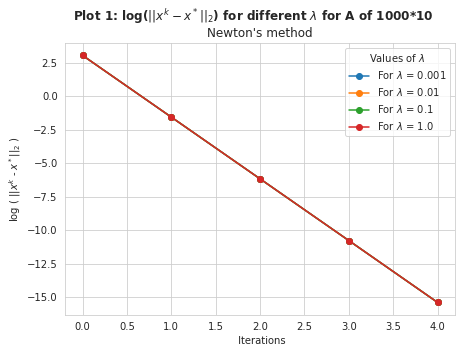

In [13]:
#Calculating log(||xk - x*||) for each k considering each starting point x^0
x_opt_newton2 = [x_array_newton2[i][-1] for i in range(len(lambda_array))]
plot_x2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(x_array_newton2[i])):
        plot_x2[i].append(np.log(np.linalg.norm(x_array_newton2[i][j] - x_opt_newton2[i])))
#Plotting log(||xk - x*||) for each k for each of the starting points x^0
fig, ax = plt.subplots(1, 1, figsize = (7,5))
fig.suptitle("Plot 1: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):
    ax.plot(np.arange(len(x_array_newton2[i])), plot_x2[i], 'o-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

# *Comment:*
- For the Newton's method, the iterates show similar convergence rates for all choices of $\lambda$.
- The Newton's method yields Q-linear convergence from the starting.

### *Question 4b:*

Preparing a different plot for plotting log$(|f(x^k)- f(x^*)|)$   against the iterations, for diferent $\lambda$ values (use different colors for different $\lambda$ values; if necessary, add zoomed versions of the plots to depict the behavior clearly, and using appropriate legend in your plots).


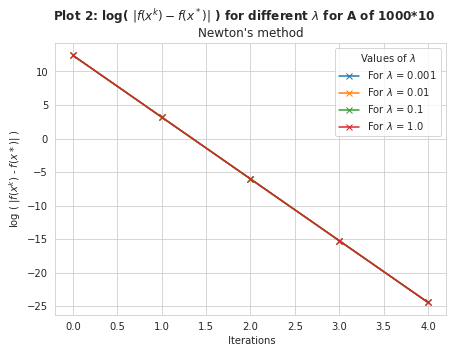

In [14]:
#Calculating log(|f(xk) - f(x*)|) for each k considering each lambda
f_opt_newton2 = [f_array_newton2[i][-1] for i in range(len(lambda_array))]
plot_fx2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(f_array_newton2[i])):
        plot_fx2[i].append(np.log(np.linalg.norm(f_array_newton2[i][j] - f_opt_newton2[i])))
#Plotting log(|f(xk) - f(x*)|) for each k for each lambda
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 2: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):
    ax.plot(np.arange(len(f_array_newton2[i])), plot_fx2[i], 'x-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("Newton's method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')

# *Comment:*
- For the Newton's method, the function values show similar convergence rates for all choices of $\lambda$.  
- The Newton's method yields Q-linear convergence from the starting.

# *Question:5*
For BFGS method preparing the following plots and discuss the relevant observations:

### *Question 5a:*
Preparing a single plot where you depict the values log$(\|x^k - x^*\|_2)$ against iterations $k = 0,1,2,...$ for
different $\lambda$ values (using different colors for different $\lambda$ values; if necessary, also adding zoomed versions of the plots to depict the behavior clearly, and using appropriate legend in your plots).

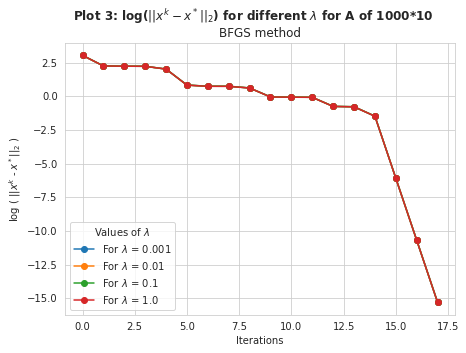

In [15]:
#Calculating log(||xk - x*||) for each k considering each starting point x^0
x_opt_bfgs2 = [x_array_bfgs2[i][-1] for i in range(len(lambda_array))]
plot_x_bfgs2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(x_array_bfgs2[i])):
        plot_x_bfgs2[i].append(np.log(np.linalg.norm(x_array_bfgs2[i][j] - x_opt_bfgs2[i])))
#Plotting log(||xk - x*||) for each k for each of the starting points x^0
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 3: log($||x^k - x^*||_2$) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):   
    ax.plot(np.arange(len(x_array_bfgs2[i])), plot_x_bfgs2[i], 'o-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("BFGS method")
ax.set_xlabel("Iterations")
ax.set_ylabel(r"log ( ||$x^k$ - $x^*||_2$ )")
ax.legend(title = 'Values of $\lambda$')

# *Comment:*
- For the BFGS method, convergence rates for all cases are the same. However, for $\lambda = 0.001,0.01, 0.1, 1$ the iterates $x^k$ are all similarly distant from the optimal $x^*$ 
- The BFGS method yields Q-quadratic at the begining but later it showed Q-superlinear convergence.

### *Question 5b:*

Preparing a different plot for plotting log$(|f(x^k)- f(x^*)|)$   against the iterations, for diferent $\lambda$ values (use different colors for different $\lambda$ values; if necessary, add zoomed versions of the plots to depict the behavior clearly, and using appropriate legend in your plots).

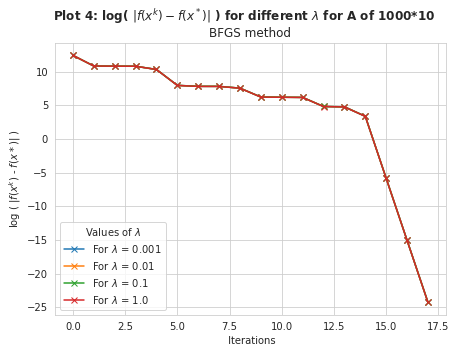

In [16]:
#Calculating log(|f(xk) - f(x*)|) for each k considering each lambda
f_opt_bfgs2 = [f_array_bfgs2[i][-1] for i in range(len(lambda_array))]
plot_fx_bfgs2 = [[] for _ in range(len(lambda_array))]
for i in range(len(lambda_array)):
    for j in range(len(f_array_bfgs2[i])):
        plot_fx_bfgs2[i].append(np.log(np.linalg.norm(f_array_bfgs2[i][j] - f_opt_bfgs2[i])))
#Plotting log(|f(xk) - f(x*)|) for each k for each lambda
fig, ax = plt.subplots(1, 1, figsize = (7,5))
fig.suptitle("Plot 4: log( $|f(x^k) - f(x^*)|$ ) for different $\lambda$ for A of 1000*10", fontweight= 'bold')
for i in range(len(lambda_array)):
    ax.plot(np.arange(len(f_array_bfgs2[i])), plot_fx_bfgs2[i], 'x-', label = f"For $\lambda$ = {lambda_array[i]}")
ax.set_title("BFGS method")
ax.set_xlabel(" Iterations")
ax.set_ylabel(r"log ( |$f(x^k)$ - $f(x*)$| )")
ax.legend(title = 'Values of $\lambda$')

# *Comment:*
- For the BFGS method, convergence rates for all cases are the same. However, for $\lambda = 0.001,0.01, 0.1, 1$ the function values $f(x^k)$ are all similarly distant from the minimum $f(x^*)$ 
- The BFGS method yields Q-quadratic at the begining but later it showed Q-superlinear convergence.

# *Question:6*

$\textbf{Answer:}$ 
- The number of iterations taken by the Newton's method is lower than that taken by the BFGS method. Similar result is shown in terms of computation time.
- The optimal $x^*$ obtained from both the methods are the same for a particular $\lambda$.